In [1]:
%pylab 

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
font = {'family' : 'arial',
#         'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
from scipy.stats import beta

In [4]:
import podpac
from podpac.datalib import smap

C:\Anaconda3\envs\podpac\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
categories_percents = [0.3, 0.2, 0.1, 0.05, 0.02]

In [6]:
path = r"\\Olympus\Projects\1010115-PIPELINE-II\Technical Work\FromMIT\beta_params_moving.zarr"
path_cosmos = r"\\OLYMPUS\Projects\1010267-SOIL-MAP-II\Technical Work\Analysis\TonziRanch.txt"
# path_cosmos = r"\\OLYMPUS\Projects\1010267-SOIL-MAP-II\Technical Work\Analysis\SMAP_OK.txt"
path_cosmos2 = path_cosmos.replace('.txt', '.csv')

In [7]:
SMAP_start_date = '2015-04-13'

In [8]:
lat_lon_coords = podpac.Coordinates([38.4316,-120.9659], ['lat', 'lon'])
# lat_lon_coords = podpac.Coordinates([36.0635,-97.2170], ['lat', 'lon'])
lat_lon_coords

Coordinates (EPSG:4326)
	lat: ArrayCoordinates1d(lat): Bounds[38.4316, 38.4316], N[1], ctype['point']
	lon: ArrayCoordinates1d(lon): Bounds[-120.9659, -120.9659], N[1], ctype['point']

In [9]:
# Condition the COSMOS file
with open(path_cosmos) as fid:
    with open(path_cosmos2, 'w') as fid2:
        for l in fid:
            new = l.split()
            new = ['T'.join(new[:2])] + new[2:]
            fid2.write(','.join(new) + '\n')

In [10]:
d = podpac.data.Zarr(source=path,  
                     cf_time=True,
                     cf_units ="days since 2018-01-01",
                     cf_calendar="proleptic_gregorian")
d

Zarr DataSource
	source: \\Olympus\Projects\1010115-PIPELINE-II\Technical Work\FromMIT\beta_params_moving.zarr
	interpolation: nearest

In [11]:
d.native_coordinates

Coordinates (EPSG:4326)
	time: ArrayCoordinates1d(time): Bounds[2018-01-01T00:00:00.000000000, 2018-12-31T00:00:00.000000000], N[365], ctype['point']
	lon: ArrayCoordinates1d(lon): Bounds[-126.3641128540039, -68.01348876953125], N[626], ctype['midpoint']
	lat: ArrayCoordinates1d(lat): Bounds[24.557823181152344, 48.84467697143555], N[276], ctype['midpoint']

In [12]:
cats_coords = podpac.coordinates.merge_dims([d.native_coordinates.drop(['lat', 'lon']), lat_lon_coords])
cats_coords

Coordinates (EPSG:4326)
	time: ArrayCoordinates1d(time): Bounds[2018-01-01T00:00:00.000000000, 2018-12-31T00:00:00.000000000], N[365], ctype['point']
	lat: ArrayCoordinates1d(lat): Bounds[38.4316, 38.4316], N[1], ctype['point']
	lon: ArrayCoordinates1d(lon): Bounds[-120.9659, -120.9659], N[1], ctype['point']

In [13]:
cats = d.eval(cats_coords)
cats

<xarray.UnitsDataArray (time: 365, lat: 1, lon: 1, output: 5)>
array([[[[0.269962, ..., 0.200482]]],


       ...,


       [[[0.26869 , ..., 0.200628]]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * lat      (lat) float64 38.43
  * lon      (lon) float64 -121.0
  * output   (output) <U2 'd0' 'd1' 'd2' 'd3' 'd4'
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x00000227DF9C5D68>
    crs:          EPSG:4326

In [14]:
porosity = smap.SMAPPorosity()
# p = porosity.eval(lat_lon_coords)
# p

In [15]:
cosmos = podpac.data.CSV(source=path_cosmos2, data_key='SOILM', time_key="YYYY-MM-DDTHH:MM", )
cosmos_d = cosmos.eval(cosmos.native_coordinates)

In [16]:
cosmos_day_mean = cosmos_d.resample(time='1D').mean()
cosmos_day_mean

<xarray.UnitsDataArray (time: 2957)>
array([10.15    , 15.275   , 15.2125  , ..., 15.918182, 15.      , 16.58    ])
Coordinates:
  * time     (time) datetime64[ns] 2011-05-10 2011-05-11 ... 2019-06-13

In [17]:
cosmos_day_mean.time.data  > np.datetime64(SMAP_start_date) 

array([False, False, False, ...,  True,  True,  True])

In [18]:
cosmos_day_mean_smap = cosmos_day_mean[cosmos_day_mean.time.data > np.datetime64(SMAP_start_date)]
cosmos_day_mean_smap

<xarray.UnitsDataArray (time: 1522)>
array([20.870833, 19.133333, 18.7125  , ..., 15.918182, 15.      , 16.58    ])
Coordinates:
  * time     (time) datetime64[ns] 2015-04-14 2015-04-15 ... 2019-06-13

In [19]:
p2_smap = cosmos_day_mean_smap.max().data.item()
p2 = cosmos_day_mean.max().data.item()
p2, p2_smap

(47.96666666666667, 47.96666666666667)

In [20]:
data_smap = cosmos_day_mean_smap[cosmos_day_mean_smap > 0] / (p2_smap*1.01)
groups_smap = data_smap.groupby('time.dayofyear')
data = cosmos_day_mean[cosmos_day_mean > 0] / (p2*1.01)
groups = data.groupby('time.dayofyear')

In [21]:
doy = []
for l, g in groups:
    doy.append(g)
doy_smap = []
for l, g in groups_smap:
    doy_smap.append(g)
doy[0], doy_smap[0]

(<xarray.UnitsDataArray (time: 7)>
 array([0.336025, 0.622424, 0.303346, 0.544331, 0.506316, 0.549577, 0.484804])
 Coordinates:
   * time     (time) datetime64[ns] 2012-01-01 2013-01-01 ... 2019-01-01,
 <xarray.UnitsDataArray (time: 3)>
 array([0.506316, 0.549577, 0.484804])
 Coordinates:
   * time     (time) datetime64[ns] 2016-01-01 2018-01-01 2019-01-01)

In [22]:
len(doy), len(doy_smap)

(366, 365)

In [23]:
ab = np.zeros((365, 2))
ab_smap = np.zeros((365, 2))
for i in range(365):
    s_i = i - 22
    s_e = i + 23
    if s_i < 0:
        samples = doy[s_i:] + doy[:s_e]
        samples_smap = doy_smap[s_i:] + doy_smap[:s_e]
    elif s_e > 365:
        samples = doy[s_i:] + doy[:s_e - 366]
        samples_smap = doy_smap[s_i:] + doy_smap[:s_e - 366]
    else:
        samples = doy[s_i:s_e]
        samples_smap = doy_smap[s_i:s_e]
#     print(i, len(samples))
    samples = np.concatenate(samples)
    samples_smap = np.concatenate(samples_smap)
    res = beta.fit(samples, floc=0, fscale=1)
    res_smap = beta.fit(samples_smap, floc=0, fscale=1)
    ab[i, :] = res[:2]
    ab_smap[i, :] = res_smap[:2]
#     print(i, samples.shape)

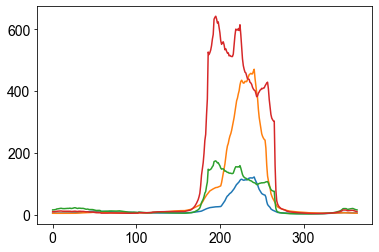

In [24]:
plot(ab)
plot(ab_smap)

In [25]:
cats_cosmos = np.zeros((365, 5))
cats_cosmos_smap = np.zeros((365, 5))
for i in range(365):
    cats_cosmos[i, :] = [beta.ppf(cp, ab[i, 0], ab[i, 1]) for cp in categories_percents]
    cats_cosmos_smap[i, :] = [beta.ppf(cp, ab_smap[i, 0], ab_smap[i, 1]) for cp in categories_percents]
cats_cosmos *= p2 / 100
cats_cosmos_smap *= p2_smap / 100

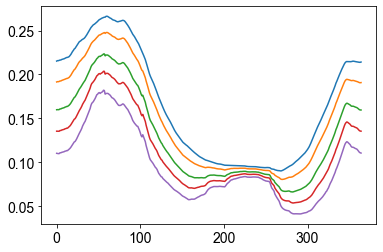

In [26]:
plot(cats_cosmos)

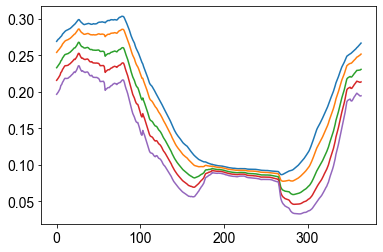

In [27]:
plot(cats_cosmos_smap)

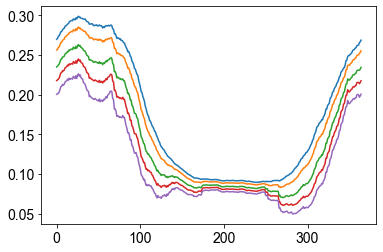

In [28]:
plot(cats[:, 0, 0, :])

Text(0, 0.5, 'Volumetric Soil \nMoisture ($m^3/m^3$)')

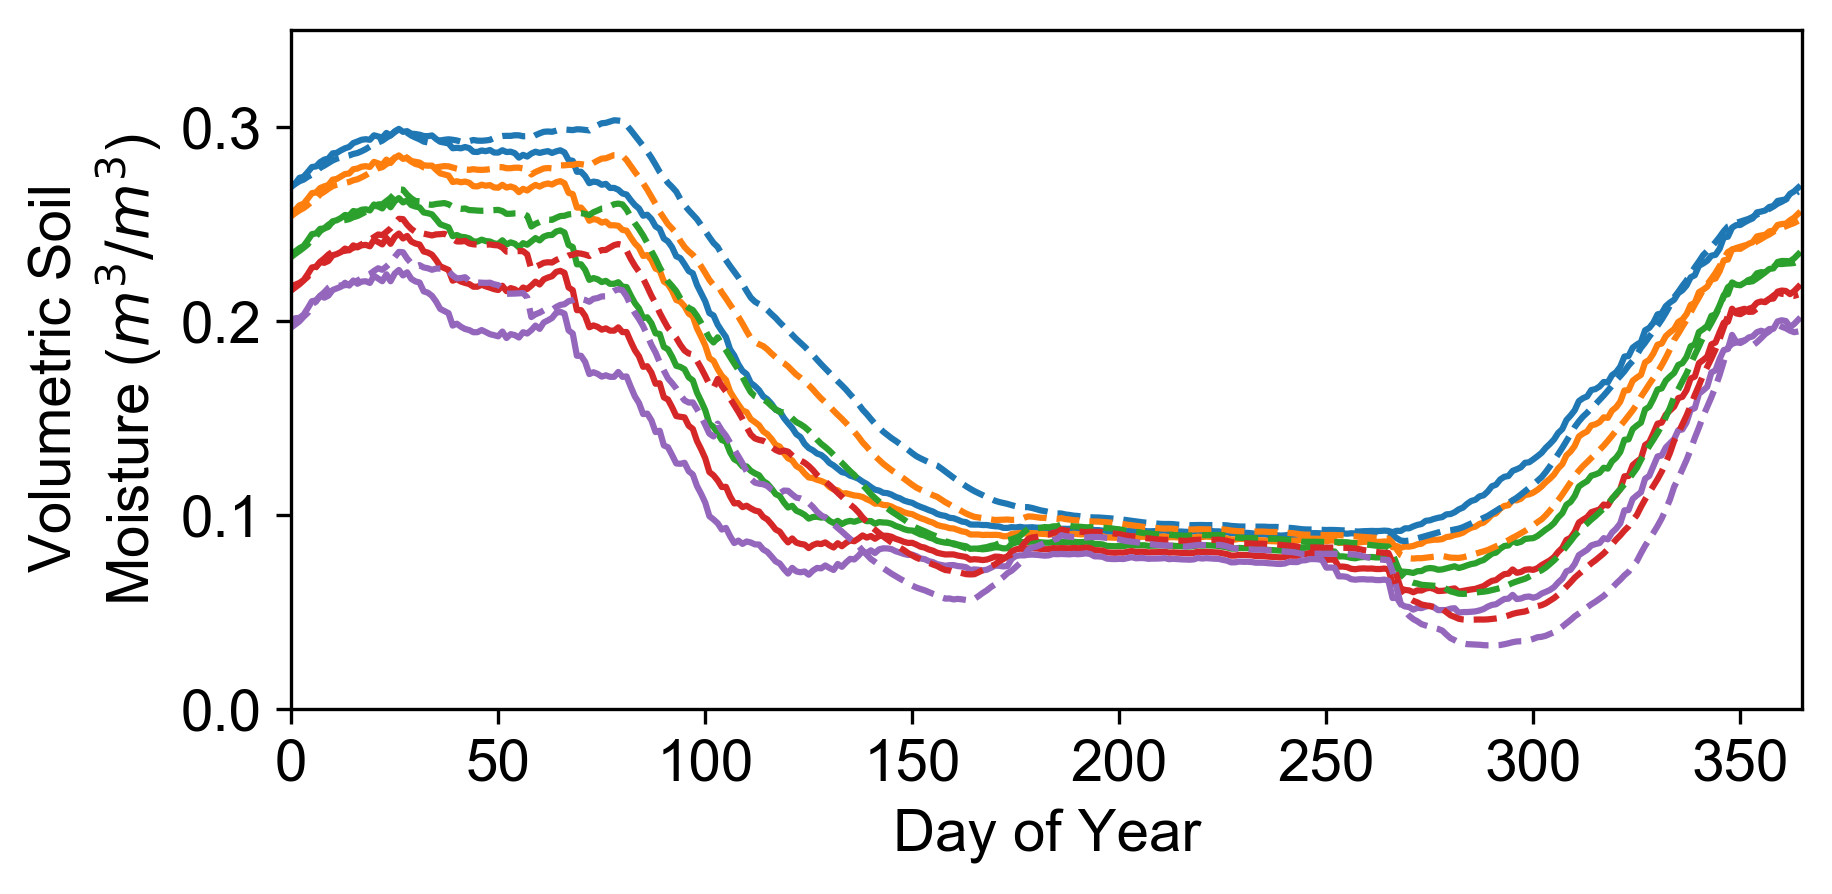

In [31]:
plt.figure(figsize=(6.5, 3), dpi=300)
plot(0, 0, 'k')
plot(0, 0, 'k--')
plot(np.arange(0, 365), cats[:, 0, 0, :])
plt.gca().set_prop_cycle(None)
plot(np.arange(0, 365), cats_cosmos_smap, '--')
ylim(0, 0.35)
xlim(0,365)
xlabel('Day of Year')
ylabel('Volumetric Soil \nMoisture ($m^3/m^3$)')
# legend(['SMAP', 'COSMOS'], loc=3)

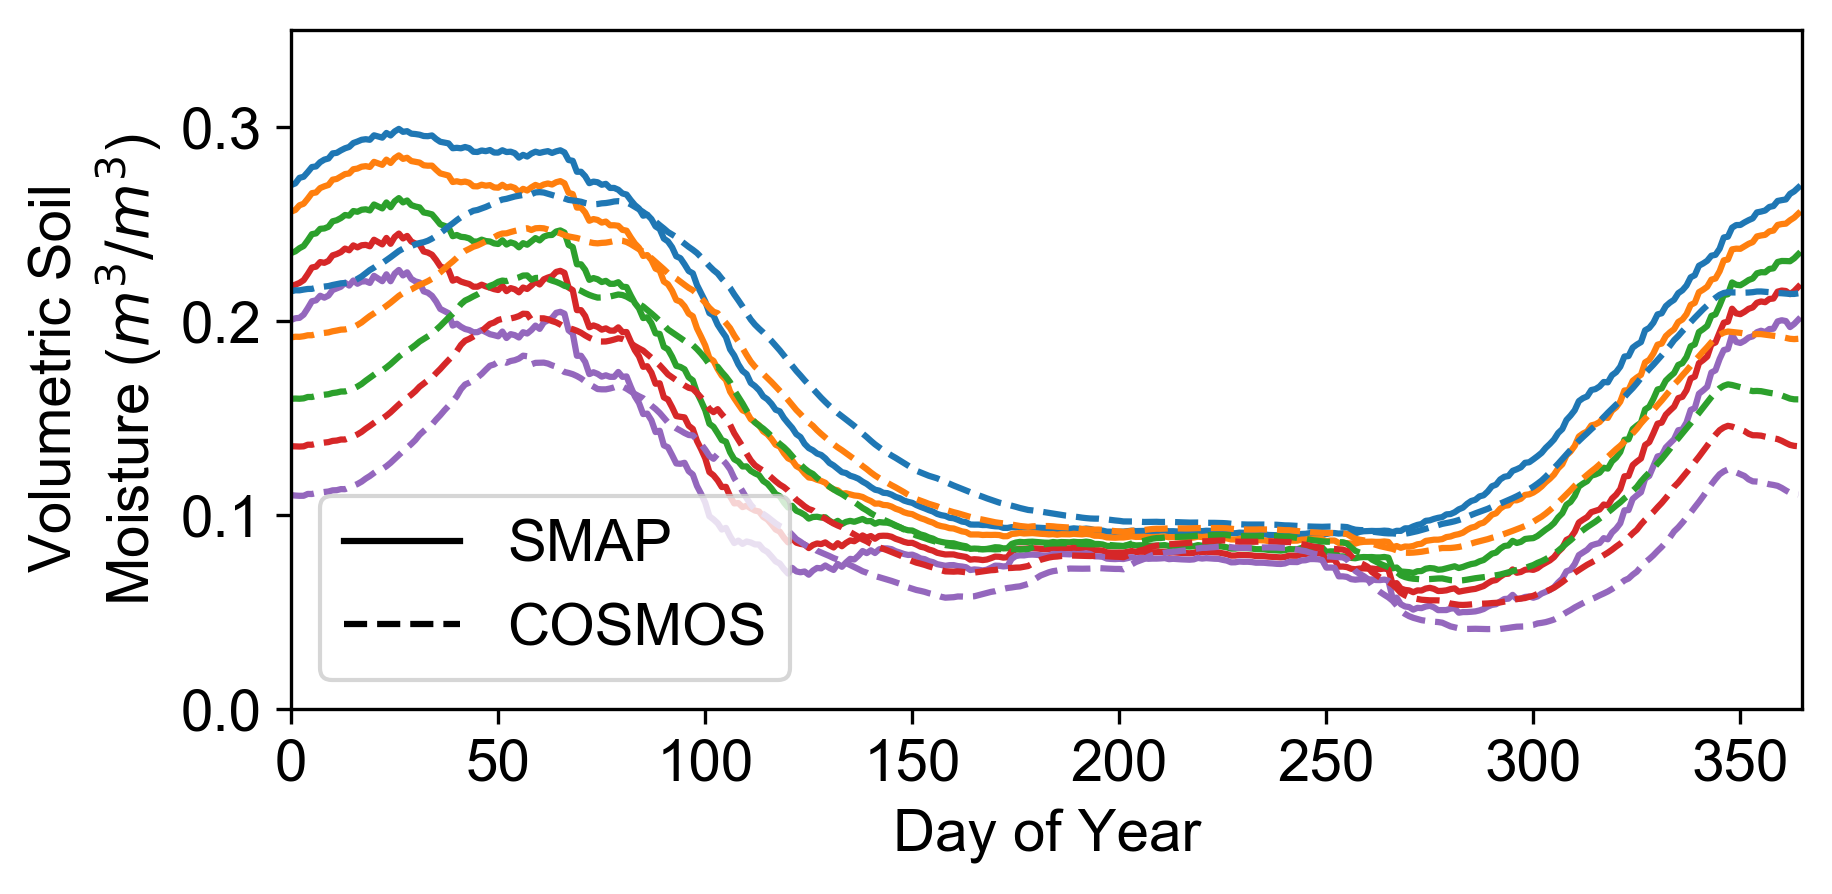

In [30]:
plt.figure(figsize=(6.5, 3), dpi=300)
plot(0, 0, 'k')
plot(0, 0, 'k--')
plot(np.arange(0, 365), cats[:, 0, 0, :])
plt.gca().set_prop_cycle(None)
plot(np.arange(0, 365), cats_cosmos, '--')
ylim(0, 0.35)
xlim(0,365)
xlabel('Day of Year')
ylabel('Volumetric Soil \nMoisture ($m^3/m^3$)')
legend(['SMAP', 'COSMOS'], loc=3)